In [2]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline


In [3]:
client = MongoClient()
db = client['CARSENSOR']
collection = db['PRIUS']

col = collection.find()
# nan を含む行を削除
df = pd.DataFrame(list(col)).dropna()

In [4]:
# DBのドキュメント例
collection.find_one()

{'_id': ObjectId('5bc2240bb2bf24158484a663'),
 'url': 'https://www.carsensor.net/usedcar/detail/CU8456803215/index.html?TRCD=200002',
 'base_price': 2430000,
 'total_price': 2590000,
 'model_year': 2018,
 'distance': 0.001,
 'repare': 'なし',
 'inspection': '新車未登録',
 'info': '1.8 S セーフティ プラス 新車 LEDヘッド （ブラック）',
 'drive': '2WD',
 'recycle': 'リ済込',
 'legal_maintenance': '法定整備付',
 'warranty': '保証付：販売店保証 保証期間：5年 保証距離：100,000km',
 'one_owner': 0,
 'record_book': 1,
 'no_smoke': 1,
 'key': 'CU8456803215',
 'region': '愛知県',
 'keyless': 1,
 'smartkey': 1,
 'navi': 0,
 'TV': 0,
 'video': 0,
 'audio': 0,
 'player': 0,
 'monitor': 0,
 'ETC': 0,
 'sheat_air': 0,
 'sheat_heater': 0,
 'idling_stop': 1,
 'AS_sensor': 0,
 'cruise': 1,
 'ABS': 1,
 'ESC': 1,
 'anti_theft': 1,
 'auto_brake': 0,
 'parking_assist': 1,
 'airbag': '運転席/助手席/サイド/－',
 'headlight': 'LED',
 'camera': 0,
 'around_camera': 0,
 'aero': 0,
 'alumi_wheel': 0,
 'lowdown': 0,
 'liftup': 0,
 'cold_area': 0}

In [59]:
variable_list = ['distance', 'keyless', 'smartkey', 'ETC', 'idling_stop', 'AS_sensor', 'cruise', 'model_year', 'navi', 'camera', 'repare']

x = df[variable_list]
y = df[['base_price']]

x_dummies = pd.get_dummies(x[variable_list[2:]]).drop(['navi_0', 'camera_0', 'repare_なし'], axis=1)
x_ = x.drop(variable_list[2:], axis=1)

x_std = StandardScaler().fit_transform(x_)
x_data = np.hstack((x_std, x_dummies.values))
x_data_df = pd.DataFrame(x_data, columns=['distance', 'model_year'] + list(x_dummies.columns))
y_data = y.values / 10000

train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3)

In [55]:
x_dummies.columns

Index(['navi_CD', 'navi_DVD', 'navi_HDD', 'navi_メモリー他', 'camera_フロント/サイド/バック',
       'camera_フロント/－/バック', 'camera_－/サイド/バック', 'camera_－/－/バック', 'repare_あり'],
      dtype='object')

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


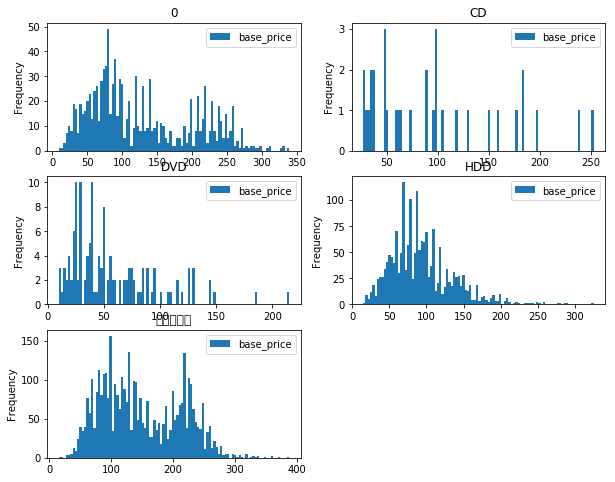

In [56]:
fig = plt.figure(figsize=(10, 8))
for (i, (key, group)) in enumerate(df.groupby('navi')):
    ax = fig.add_subplot(3, 2, i+1)
    fig.subplots_adjust()
    group.loc[:, 'base_price'] = group['base_price'] / 10000
    group.plot(x='distance', y='base_price', kind='hist', bins=100, ax=ax)
    ax.set_title(key)


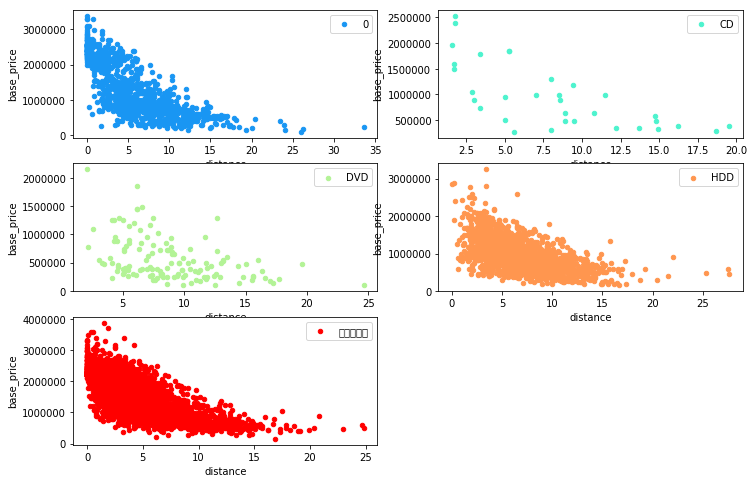

In [57]:
num_models = len(df['navi'].unique())

fig = plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('rainbow')
colors = [cmap(c / float(num_models)) for c in np.arange(1, num_models + 1)]
for (i, (key, group)) in enumerate(df.groupby('navi')):
    ax = fig.add_subplot(3, 2, i+1)
    group.plot.scatter(x='distance', y='base_price', ax=ax, color=colors[i], label=key)

In [64]:
df[df['camera']=='－/サイド/バック'].shape

(6, 46)

In [62]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

clf.fit(x_data, y_data)

print(pd.DataFrame({'Name': x_data_df.columns, 'Coefficient': clf.coef_.reshape(-1)}))
print(clf.intercept_)

print('\nR2 score:', clf.score(x_data, y_data))
print('adjusted R2 score: ', 1 - (1-clf.score(x_data, y_data))*(len(y_data)-1)/(len(y_data)-x_data.shape[1]-1))

                   Name  Coefficient
0              distance   -18.143047
1            model_year    46.609529
2               navi_CD    15.226175
3              navi_DVD    18.648305
4              navi_HDD    -3.945763
5            navi_メモリー他    -7.094143
6   camera_フロント/サイド/バック    18.968228
7     camera_フロント/－/バック    18.819363
8      camera_－/サイド/バック     0.327379
9        camera_－/－/バック     6.052875
10            repare_あり   -12.970679
[130.20909919]

R2 score: 0.8274770833066409
adjusted R2 score:  0.8272026036879503


In [12]:
x = df['distance'].values
y = df['base_price'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)

train_x = train_x.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

clf = linear_model.LinearRegression()
clf.fit(train_x, train_y)
print('R2 score:', clf.score(test_x, test_y))
print('adjusted R2 score: ', 1 - (1-clf.score(test_x, test_y))*(len(test_y)-1)/(len(test_y)-test_x.shape[1]-1))

R2 score: 0.5188843021109675
adjusted R2 score:  0.5186525508114063


In [77]:
test_y.shape

(1, 1730)

In [52]:
x_data_df.columns

Index(['distance', 'model_year', 'AS_sensor', 'cruise', 'navi_0', 'navi_CD',
       'navi_DVD', 'navi_HDD', 'navi_メモリー他', 'camera_0', 'camera_フロント/サイド/バック',
       'camera_フロント/－/バック', 'camera_－/サイド/バック', 'camera_－/－/バック'],
      dtype='object')

In [25]:
x_dummies

,AS_sensor,cruise,navi_0,navi_CD,navi_DVD,navi_HDD,navi_メモリー他,camera_0,camera_フロント/サイド/バック,camera_フロント/－/バック,camera_－/サイド/バック,camera_－/－/バック
0,0,1,1,0,0,0,0,1,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,1
2,1,1,1,0,0,0,0,1,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,0,1
4,1,1,1,0,0,0,0,0,0,0,0,1
5,1,1,1,0,0,0,0,1,0,0,0,0
6,1,1,1,0,0,0,0,0,0,0,0,1
7,1,1,1,0,0,0,0,0,0,0,0,1
8,1,1,1,0,0,0,0,0,0,0,0,1
9,1,1,1,0,0,0,0,0,0,0,0,1
